# Starbucks Capstone Project Notebook

## Project Overview
This project is the Capstone project of the Udacity Machine Learning Engineer Nanodegree. The data set contain simulated data that mimics customer behaviour on the Starbucks rewards mobile app. The data has been simplified so as to only contain one product. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. Not all users receive the same offer, and that is the challenge to solve with this data set.

## Problem Statement
The aim of this project is to create a model looking at customers who had either completed and offer without viewing or before they had viewed the offer and customers who did not complete the offer.
Once a model to predict whether a user would naturally have completed an offer has been created the evaluation can be extended and used to predict whether or not the users who had viewed and completed the offer would have done so naturally anyway and calculate whether the offers generated additional revenue.

## Import Packages

In [1]:
# data processing
import pandas as pd
import numpy as np
# data visualisation
from matplotlib import pyplot as plt
import seaborn as sns
# machine learning packages and classes
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split

# set to ensure work is reproducible
RANDOM_STATE = 1
% matplotlib inline

## Load Data

In [2]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Processing

### Create functions to process the porfolio data

In [3]:
def create_column_pivot(df, column):
    """ Updates a list of Pandas DataFrame column names
    INPUT:
        df: Pandas DataFrame object
        column: column used to pivot the data on
    OUTPUT:
        df: Updated Pandas DataFrame"""
    pivot_df = pd.DataFrame(columns=['index', column, 'count'])
    for idx, row in df.iterrows():
        for col_val in row[column]:
            pivot_df = pivot_df.append({'index':idx, column:col_val, 'count':1}, ignore_index=True)    
    pivot_df = pd.pivot_table(data=pivot_df, index='index', columns=column, values='count', aggfunc='count', fill_value=0)
    df = df.join(pivot_df, how='left')
    df.drop(columns=[column], inplace=True)
    return df

def create_dummy_variables(df, column, dtype=float):
    """ Updates a list of Pandas DataFrame column names
    INPUT:
        df: Pandas DataFrame object
        column: the column used to create the dummy variables
        dtype: defines the type of the dummy variable values
    OUTPUT:
        df: Updated Pandas DataFrame with the new column names"""
    dummy_df = pd.get_dummies(df[column], dtype=dtype)
    df = df.join(dummy_df, how='left')
    df.drop(columns=[column], inplace=True)
    return df

def rename_columns(df, old_names, new_names):
    """ Updates a list of Pandas DataFrame column names
    INPUT:
        df: Pandas DataFrame object
        old_names: list of strings that stores the old column names
        new_names: list of strings that stores the new column names
    OUTPUT:
        df: Updated Pandas DataFrame with the new column names"""
    names_mapping = {old_names[i]:new_names[i] for i in range(len(old_names))}
    df.rename(columns=names_mapping, inplace=True)
    return df
    
def process_portfolio_data(df):
    """ Processes the data in the portfolio DataFrame to be used later on
    INPUT:
        df: Pandas DataFrame object
    OUTPUT:
        df: Updated Pandas DataFrame"""
    df = create_column_pivot(df, 'channels')
    df = create_dummy_variables(df, 'offer_type')
    df = rename_columns(df, ['id', 'duration'], ['offer_id', 'duration_days'])
    # is set to one for all records therefore it adds no predictive value
    df.drop(columns=['email'], inplace=True)
    return df


In [4]:
portfolio = process_portfolio_data(portfolio)

### Create functions to process the profile data

In [5]:
def define_age_groups(df):
    """ Processes the age data and creates groups for them
    INPUT:
        df: Pandas DataFrame object
    OUTPUT:
        df: Updated Pandas DataFrame"""
    bins= [-1,18,31,51,71, 110]
    labels = ['Unknown','18 - 30','31-50', '51-70','70+']
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
    df = create_dummy_variables(df, 'age_group')
    return df

def process_profile_data(df):
    """ Processes the data in the profile DataFrame to be used later on
    INPUT:
        df: Pandas DataFrame object
    OUTPUT:
        df: Updated Pandas DataFrame"""
    df = df.dropna()
    df = create_dummy_variables(df, 'gender')
    df = rename_columns(df, ['F', 'M', 'O'], ['Female', 'Male', 'Other'])
    DATE_TO_YEAR_DENOMINATOR = 10000
    df.loc[:, 'year_joined'] = df.loc[:, 'became_member_on'] // DATE_TO_YEAR_DENOMINATOR
    df = create_dummy_variables(df, 'year_joined')
    plot_histogram(df, column='income', bins=10, title='Income Distribution', xlabel='Income ($)')
    MAX_CUSTOMER_INCOME = 120000
    df.loc[:, 'income'] = df.loc[:, 'income'] / MAX_CUSTOMER_INCOME
    df = define_age_groups(df)
    df.rename(columns={'id':'customer_id'}, inplace=True)
    plot_histogram(df, column='age', bins=20, title='Age distribution after processing', xlabel='Age')
    df.drop(columns=['became_member_on', 'Other', 2013, 'age', '70+', 'Unknown'], inplace=True)
    return df

def plot_histogram(df, column, bins, title='', xlabel=''):
    """ Processes the data in the profile DataFrame to be used later on
    INPUT:
        df: Pandas DataFrame object
        column: column in the DataFrame that the histogram will plot
        bins: number of bins the histogram is split into
        title: title of the output graph
        xlabel: label for the x-axis in the graph
    OUTPUT: histogram image
    """
    plt.title(title)
    plt.hist(df.loc[:, column], bins=bins)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.show()

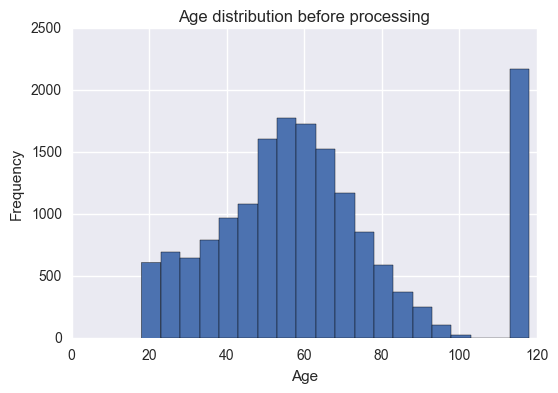

In [6]:
# plot age histogram
plot_histogram(profile, column='age', bins=20, title='Age distribution before processing', xlabel='Age')

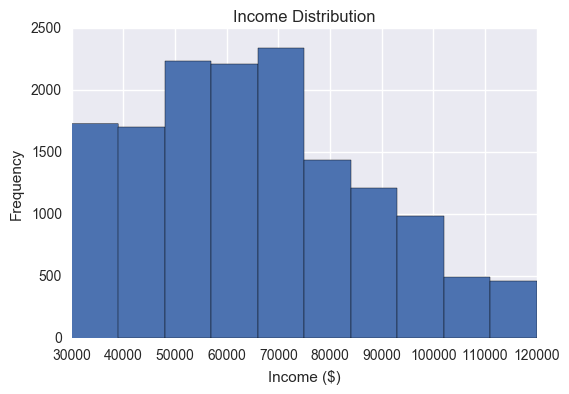

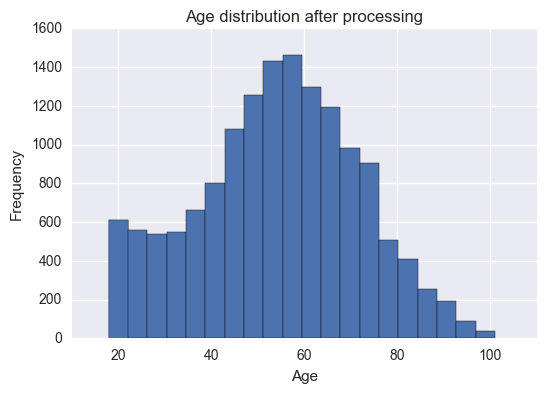

In [7]:
profile = process_profile_data(profile)

### Create functions to process the transcript data

In [8]:
def split_transcript_data(df, portfolio, profile):
    """ Processes the data in the profile DataFrame to be used later on
    INPUT:
        df: Pandas DataFrame object
        portfolio: portfolio DataFrame
        profile: profile DataFrame
    OUTPUT:
        offer_events: Pandas DataFrame containing data on customer offers
        transactions: Pandas DataFrame containing data on customer transactions"""
    # convert time from hours into days
    HOURS = 24
    df.loc[:, 'time_days'] = df.loc[:, 'time'] / HOURS
    # validate if the event is an offer or transaction event
    df.loc[:, 'is_offer'] = [1 if x != 'transaction' else 0 for x in df['event']]
    df.rename(columns={'person':'customer_id'}, inplace=True)
    df = df.loc[df.customer_id.isin(profile.customer_id), :]
    # get the offer events and pull out the offer id
    offer_events = df.loc[df.is_offer == 1, :]
    offer_events.loc[offer_events.event != 'offer completed', 'offer_id'] = offer_events.loc[offer_events.event != 'offer completed', 'value'].apply(lambda x: x.get('offer id'))
    offer_events.loc[offer_events.event == 'offer completed', 'offer_id'] = offer_events.loc[offer_events.event == 'offer completed', 'value'].apply(lambda x: x.get('offer_id'))
    offer_events = offer_events.join(portfolio.loc[:, ['offer_id', 'duration_days', 'informational']].set_index('offer_id'), on='offer_id')
    # get all the transactions and their values
    transactions = df.loc[df.is_offer == 0, :]
    transactions.loc[:, 'amount'] = transactions['value'].apply(lambda x: x.get('amount'))
    return offer_events, transactions

offer_events, transactions = split_transcript_data(transcript, portfolio, profile)

def find_time_periods_for_each_received_offer(df):
    """ Processes the data to find when an offer started and ended (assumes the offer ends when the duration is up or the customer receives a new offer)
    INPUT:
        df: Pandas DataFrame object
    OUTPUT:
        df: Updated Pandas DataFrame"""
    df = df.loc[df.event == 'offer received', ['customer_id', 'offer_id', 'time_days', 'duration_days', 'is_offer']]
    df.loc[:, 'rank'] = df.groupby('customer_id')['time_days'].rank("dense", ascending=True)
    df.loc[:, 'next_rank'] = df['rank'] + 1
    df = df.join(df.set_index(['customer_id', 'rank']), on=['customer_id', 'next_rank'], rsuffix='_next')
    df.loc[:, 'start_time'] = df['time_days']
    df.loc[:, 'end_time'] = df['time_days'] + df['duration_days']
    df.loc[df['time_days_next'].notnull(), 'end_time'] = np.minimum(df.loc[df['time_days_next'].notnull(), 'end_time'], df.loc[df['time_days_next'].notnull(), 'time_days_next'])
    df = df.loc[:, ['customer_id', 'offer_id', 'rank', 'start_time', 'end_time']]
    return df
    
offers_received = find_time_periods_for_each_received_offer(offer_events)

def find_spend_during_offers(transactions, offers):
    """ Combines the offer and transaction DataFrames to find the spend during the offer period
    INPUT:
        transactions: Pandas DataFrame object
        offers: Pandas DataFrame object
    OUTPUT:
        transactions: Updated transactions Pandas DataFrame"""
    transactions = transactions.join(offers.set_index(['customer_id']), on=['customer_id'])
    transactions = transactions.loc[(transactions['time_days'] >= transactions['start_time']) & (transactions['time_days'] < transactions['end_time']), :]
    transactions = transactions.groupby(['customer_id', 'offer_id', 'start_time']).agg({'time_days':'min'})
    transactions.rename(columns={'time_days':'first_transaction'}, inplace=True)
    return transactions
    
transactions = find_spend_during_offers(transactions, offers_received)

def define_offer_status(df):
    """ Processes the data to create the target variable for the models
        df: Pandas DataFrame object
    OUTPUT:
        df: Updated Pandas DataFrame"""
    df.loc[:, 'offer_completion_status'] = 0
    df.loc[df['offer_completed'] == 1, 'offer_completion_status'] = 1
    df.loc[(df['offer_completed'] == 1) & (df['offer_completed_time'] >= df['offer_viewed_time']), 'offer_completion_status'] = 2
    return  df

def pivot_offer_events(df):
    """ Pivot the offer events data to find out the order in which events occured
        df: Pandas DataFrame object
    OUTPUT:
        df: Updated Pandas DataFrame"""
    df = pd.pivot_table(df, index=['customer_id', 'offer_id', 'rank', 'start_time','end_time', 'informational', 'first_transaction'], columns='event', values='time_days', aggfunc=['max', 'count'], fill_value=0)
    df.columns = ['offer_completed_time', 'offer_received_time', 'offer_viewed_time', 'offer_completed', 'offer_received', 'offer_viewed']
    df.reset_index(inplace=True)    
    df.loc[(df['first_transaction'] >= df['offer_received_time']) & (df['informational'] == 1), 'offer_completed'] = 1
    df.loc[df['informational'] == 1, 'offer_completed_time'] = df['first_transaction']    
    return df

def calculate_previous_completion_rate(df):
    """ Finds the customers previous completion rate and adds it as a feature in the data
        df: Pandas DataFrame object
    OUTPUT:
        df: Updated Pandas DataFrame"""
    df.sort_values(by=['customer_id', 'rank'], inplace=True)
    df.loc[:, 'completed_sum'] = df.groupby('customer_id')['offer_completed'].cumsum()
    df.loc[:, 'completed_sum'] -= df['offer_completed']
    df.loc[df['rank'] == 1, 'pct_previous_completed'] = 0
    df.loc[df['rank'] > 1, 'pct_previous_completed'] = df['completed_sum'] / (df['rank'] - 1)
    return df
    
def find_offer_status(offer_events, offers_received, transactions):
    """ Processes the offer events data in order to find key information on the order of offer events and whether the offers were completed
        offer_events: Pandas DataFrame object
        offers_received: Pandas DataFrame object
        transactions: Pandas DataFrame object
    OUTPUT:
        offer_events: Updated Pandas DataFrame"""
    offer_events = offer_events.join(offers_received.set_index(['customer_id', 'offer_id']), on=['customer_id', 'offer_id'])
    offer_events = offer_events.loc[(offer_events['time_days'] >= offer_events['start_time']) & (offer_events['time_days'] <= offer_events['end_time']), :]
    offer_events = offer_events.join(transactions, on=['customer_id', 'offer_id', 'start_time'])
    offer_events.first_transaction.fillna(0, inplace=True)
    offer_events = pivot_offer_events(offer_events)
    offer_events = calculate_previous_completion_rate(offer_events)
    offer_events = define_offer_status(offer_events)
    offer_events.drop(columns=['rank', 'offer_completed_time', 'offer_received_time', 'offer_viewed_time', 'offer_completed', 'offer_received', 'offer_viewed', 'completed_sum', 'informational', 'start_time', 'end_time', 'first_transaction'], inplace=True)
    return offer_events

C:\Users\Andreas\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Andreas\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
offer_events = find_offer_status(offer_events, offers_received, transactions)

## Combine the data together


In [10]:
data = offer_events.join(profile.set_index('customer_id'), on='customer_id', how='inner')
data = data.join(portfolio.set_index('offer_id'), on='offer_id', how='inner')
data.drop(columns=['customer_id', 'offer_id'], inplace=True)
data = data.loc[data['informational'] == 0, :]
data.drop(columns=['informational', 'bogo'], inplace=True)

## Split the data for model building and then assessing the campaigns successes  (phase 1 & 2)

In [11]:
phase_one = data.loc[data['offer_completion_status'] < 2, :]
phase_two = data.loc[data['offer_completion_status'] == 2, :]

## Assess correlation between the features

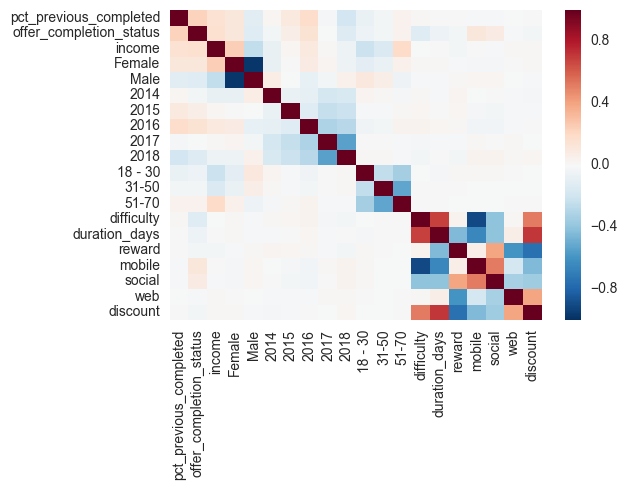

In [12]:
feature_correlation = phase_one.corr()
# plot the heatmap
sns.heatmap(feature_correlation)

## Explore the income feature against offer status

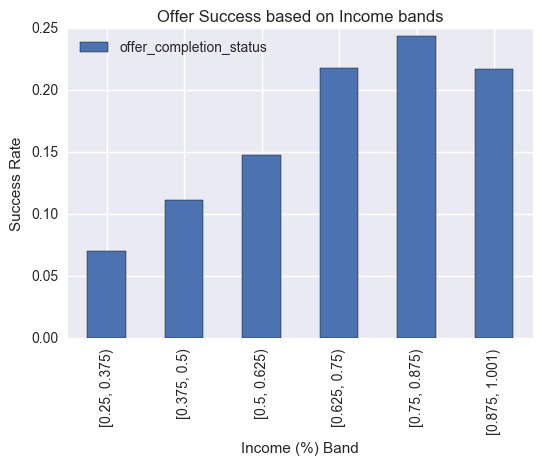

In [13]:
def plot_offer_success_based_on_income(df):
    """ Creates a bar chart of the offer success rate based on income bands
    INPUT:
        df: Pandas DataFrame object
    OUTPUT: bar graph image
    """
    income_success_data = df.loc[:, ['income', 'offer_completion_status']]
    income_success_data.loc[:, 'income_grouped'] = pd.cut(phase_one.loc[:, 'income'], bins=6, right=False)
    income_success_data.groupby('income_grouped').agg({'offer_completion_status':'mean'}).plot(kind='bar')
    plt.title('Offer Success based on Income bands')
    plt.xlabel('Income (%) Band')
    plt.ylabel('Success Rate')
    plt.show()

plot_offer_success_based_on_income(phase_one)

## Create & Balance the training set

In [14]:
def create_X_and_y(df):
    """ Splits the data in input and target vectors
        df: Pandas DataFrame object
    OUTPUT:
        X: Model input variables
        y: Model target values"""
    y = df.loc[:, 'offer_completion_status']
    X = df.drop(columns='offer_completion_status')
    return X, y
    
def balance_training_set(X, y, oversample=True):
    """ Balances the classes in the training data
        X: Model input variables
        y: Model target values
        oversample: Binary flag for whether to over or under sample
    OUTPUT:
        X: Updated model input variables
        y: Updated model target values"""
    Xy = pd.concat([X, y], axis=1)
    count_class_0, count_class_1 = Xy['offer_completion_status'].value_counts()
    df_class_0 = Xy[Xy['offer_completion_status'] == 0]
    df_class_1 = Xy[Xy['offer_completion_status'] == 1]
    if oversample:
        df_class_1_over = df_class_1.sample(count_class_0, replace=True, random_state=RANDOM_STATE)
        Xy = pd.concat([df_class_0, df_class_1_over], axis=0)
    else:
        df_class_0_under = df_class_0.sample(count_class_1, random_state=RANDOM_STATE)
        Xy = pd.concat([df_class_0_under, df_class_1], axis=0)
    X, y = create_X_and_y(Xy)
    return X, y

X, y = create_X_and_y(phase_one)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

X_train, y_train = balance_training_set(X_train, y_train, oversample=True)

## Train the models

In [15]:
def train_model(clf, parameters, X_train, y_train):
    """ Performs a grid search and trains the model
        clf: Classifier to be trained and tuned
        parameters: The dictionary of different parameter values to be tested in the grid search
        X_train: Model input variables
        y_train: Model target values
    OUTPUT:
        model: GridSearchCV object which contains the best estimator model"""
    CV_FOLDS = 5
    N_JOBS = 8
    model = GridSearchCV(estimator = clf, scoring='roc_auc', param_grid = parameters, cv = CV_FOLDS, verbose=3, n_jobs=N_JOBS)
    model.fit(X_train, y_train)
    return model

## Gradient Boosted Classifier
gb_clf = GradientBoostingClassifier(random_state=RANDOM_STATE) 
gb_parameters = {'n_estimators':[100, 150, 200], 'subsample':[0.6, 0.8, 1], 'max_features':[None, 'auto'], 'loss':['deviance', 'exponential']}
gb_model = train_model(gb_clf, gb_parameters, X_train, y_train)

## RandomForest
rf_clf = RandomForestClassifier(random_state=RANDOM_STATE, max_samples=0.6)
rf_parameters = {'max_depth':[5, 8, 10], 'n_estimators':[100, 150, 200], 'max_features':['sqrt', 'log2']}
rf_model = train_model(rf_clf, rf_parameters, X_train, y_train)

## LogisticRegression
lr_clf = LogisticRegression(random_state=RANDOM_STATE)
lr_parameters = {'penalty':['l1', 'l2', 'elasticnet'], 'C':[0.5, 1, 1.5], 'solver':['liblinear', 'saga', 'lbfgs']}
lr_model = train_model(lr_clf, lr_parameters, X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    8.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   58.6s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:  1.6min finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  90 out of  90 | elapsed:   21.6s finished


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   11.3s
[Parallel(n_jobs=8)]: Done 135 out of 135 | elapsed:   11.8s finished
C:\Users\Andreas\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Evaluate the model training and test performances

model accuracy: 0.500
model roc_auc-score: 0.500
model accuracy: 0.733
model roc_auc-score: 0.733
model accuracy: 0.800
model roc_auc-score: 0.800
model accuracy: 0.707
model roc_auc-score: 0.707
model accuracy: 0.864
model roc_auc-score: 0.500
model accuracy: 0.716
model roc_auc-score: 0.717
model accuracy: 0.740
model roc_auc-score: 0.717
model accuracy: 0.711
model roc_auc-score: 0.711


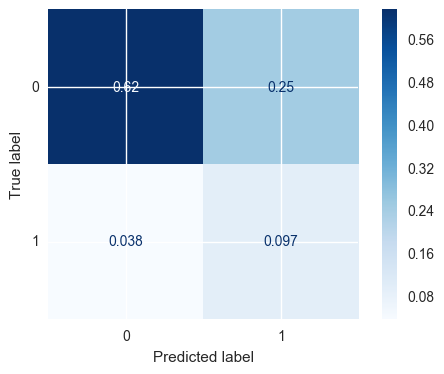

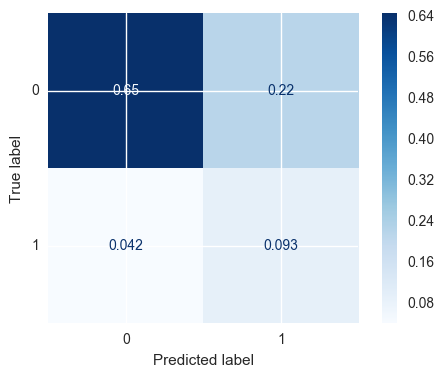

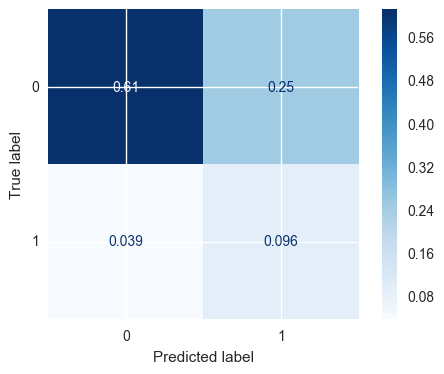

In [16]:
def evaluate_model_performance(clf, X, y, test=False):
    """ Tests the model against AUC and accuracy
        clf: Trained Classifier (Best estimator from the grid search))
        X: Model input variables
        y: Model target values
        test: Binary variable defining whether the evaluation is on training or test data
    OUTPUT:
        None unless the test flag is True then an image is returned"""
    y_pred = clf.predict(X)
    if test:
        plot_confusion_matrix(clf, X, y, cmap=plt.cm.Blues, normalize='all')
    clf_accuracy = accuracy_score(y, y_pred)
    clf_roc_auc_score = roc_auc_score(y, y_pred)
    print("model accuracy: %.3f" % (clf_accuracy))
    print("model roc_auc-score: %.3f" % (clf_roc_auc_score))

def baseline_model_performance(y):
    """ Tests the baseline model against AUC and accuracy
        y: Model target values
    OUTPUT:
        None unless the test flag is True then an image is returned"""
    y_pred = np.zeros(len(y))
    clf_accuracy = accuracy_score(y, y_pred)
    clf_roc_auc_score = roc_auc_score(y, y_pred)
    print("model accuracy: %.3f" % (clf_accuracy))
    print("model roc_auc-score: %.3f" % (clf_roc_auc_score))

##TRAIN
baseline_model_performance(y_train)
evaluate_model_performance(gb_model.best_estimator_, X_train, y_train)
evaluate_model_performance(rf_model.best_estimator_, X_train, y_train)
evaluate_model_performance(lr_model.best_estimator_, X_train, y_train)

##TEST
baseline_model_performance(y_test)
evaluate_model_performance(gb_model.best_estimator_, X_test, y_test, test=True)
evaluate_model_performance(rf_model.best_estimator_, X_test, y_test, test=True)
evaluate_model_performance(lr_model.best_estimator_, X_test, y_test, test=True)

### Create feature importance graphs

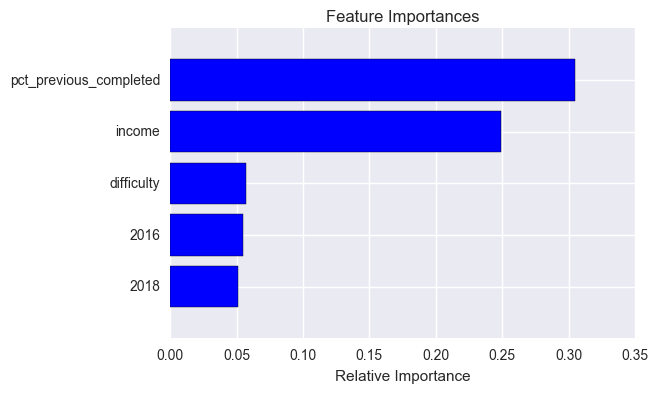

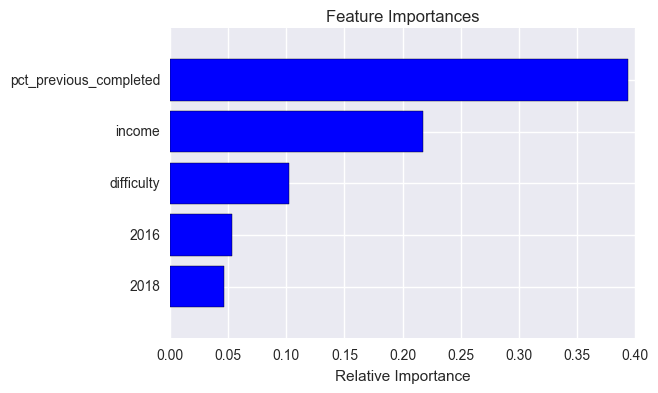

In [17]:
def create_feature_importance_graph(clf, features=None):
    """ Used for the ensemble models to show relative feature importance in the trained models
        clf: Trained Classifier (Best estimator from the grid search))
        features: Either None or an integer between 1 and the number of features
    OUTPUT:
        Feature importance graph"""
    feature_names = X_train.columns
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    if features != None:
        indices = indices[:features]
    indices = indices[::-1]
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

create_feature_importance_graph(rf_model.best_estimator_, features=5)
create_feature_importance_graph(gb_model.best_estimator_, features=5)


# Phase Two - Assessing the overall offer success

## Create predictions

In [18]:
X_phase_two, y_phase_two = create_X_and_y(phase_two)

y_pred_phase_two = rf_model.best_estimator_.predict(X_phase_two)
y_prob_phase_two = rf_model.best_estimator_.predict_proba(X_phase_two)

print(np.mean(y_pred_phase_two))
print(np.mean(y_prob_phase_two[:, 1]))

0.6182908545727136
0.5528759029339038


## Chart distribution of probabilites

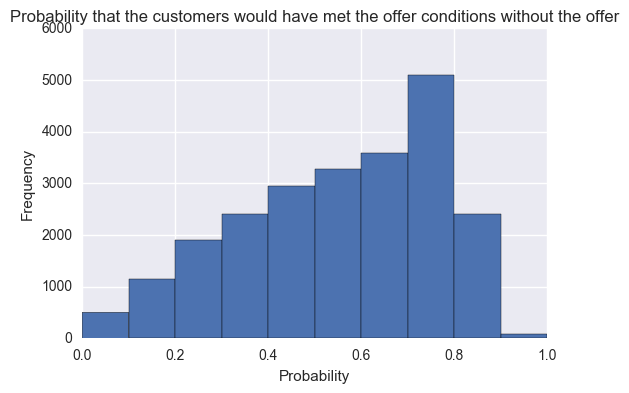

In [19]:
y_prob_phase_two_df = pd.DataFrame(y_prob_phase_two[:, 1], columns=['probability'])
plot_histogram(y_prob_phase_two_df, column='probability', bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], title='Probability that the customers would have met the offer conditions without the offer', xlabel='Probability')

## Calculate net increase in revenue

In [20]:
def calculate_net_increase_in_revenue(weights, reward, difficulty, reward_ratio):
    """ Finds the predicted net increase in revenue from the offers
        weights: numpy array containing either the predicted outcome or probability of outcome '1' occuring
        reward: pandas Series containing the offer reward values
        difficulty: pandas Series containing the offer difficulty values
    OUTPUT:
        Print statements containing the calculated number"""
    increase_in_revenues = sum((1-weights) * (difficulty - (reward*reward_ratio)))
    increase_in_costs = sum(weights * (reward*reward_ratio))
    print("actual cost of reward ratio: %.2f" % (reward_ratio))
    print("increase in revenues: %.2f" % (increase_in_revenues))
    print("increase in costs: %.2f" % (increase_in_costs))
    print("net increase in revenue/loss: %.2f" % (increase_in_revenues - increase_in_costs))

for ratio in [0.25, 0.5, 0.75]:
    calculate_net_increase_in_revenue(y_pred_phase_two, phase_two.loc[:, 'reward'], phase_two.loc[:, 'difficulty'], reward_ratio=ratio)

for ratio in [0.25, 0.5, 0.75]:
    calculate_net_increase_in_revenue(y_prob_phase_two[:,1], phase_two.loc[:, 'reward'], phase_two.loc[:, 'difficulty'], reward_ratio=ratio)

actual cost of reward ratio: 0.25
increase in revenues: 79981.00
increase in costs: 17784.25
net increase in revenue/loss: 62196.75
actual cost of reward ratio: 0.50
increase in revenues: 68655.00
increase in costs: 35568.50
net increase in revenue/loss: 33086.50
actual cost of reward ratio: 0.75
increase in revenues: 57329.00
increase in costs: 53352.75
net increase in revenue/loss: 3976.25
actual cost of reward ratio: 0.25
increase in revenues: 87759.37
increase in costs: 15954.48
net increase in revenue/loss: 71804.88
actual cost of reward ratio: 0.50
increase in revenues: 74603.60
increase in costs: 31908.96
net increase in revenue/loss: 42694.63
actual cost of reward ratio: 0.75
increase in revenues: 61447.83
increase in costs: 47863.45
net increase in revenue/loss: 13584.38
